In [1]:
import torch 
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

print(torch.__version__)

1.7.0+cu101


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Load FMNIST dataset
fmnist_train = torchvision.datasets.FashionMNIST(
    root = 'drive/MyDrive/pytorch/practice2/fashionMNIST_data/',
    train = True,
    transform = transforms.ToTensor(),
    download=True
)

fmnist_test = torchvision.datasets.FashionMNIST(
    root = 'drive/MyDrive/pytorch/practice2/fashionMNIST_data/',
    train = False,
    transform = transforms.ToTensor(),
    download=True
)

In [4]:
# Dataset Loader
train_loader = torch.utils.data.DataLoader(fmnist_train,
                                           batch_size=100,
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(fmnist_test,
                                          batch_size=100,
                                          shuffle=False)

In [5]:
# Check data
for data in train_loader:
  print("Data: ", data)
  break

Data:  [tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0

In [10]:
# Create Model
class fCNN(nn.Module):
  def __init__(self):
    super(fCNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.drop1 = nn.Dropout(0.25)
    self.drop2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(12544, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    out = self.conv1(x)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.drop1(out)
    out = torch.flatten(out, 1)
    out = self.fc1(out)
    out = F.relu(out)
    out = self.drop2(out)
    out = self.fc2(out)

    # output = F.softmax(out, dim=1)
    return out

In [11]:
model = fCNN().to(device)

In [12]:
# Define cost/loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

fCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout(p=0.25, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [13]:
num_epochs = 20
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    count += 1

    if not (count % 50):
      total = 0
      correct = 0

      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)

        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(
          count, loss.data, accuracy
      ))

Iteration: 500, Loss: 0.5337297320365906, Accuracy: 85.98999786376953%
Iteration: 1000, Loss: 0.2708646059036255, Accuracy: 88.22000122070312%
Iteration: 1500, Loss: 0.5125744342803955, Accuracy: 88.97999572753906%
Iteration: 2000, Loss: 0.19254806637763977, Accuracy: 89.41999816894531%
Iteration: 2500, Loss: 0.28562942147254944, Accuracy: 90.63999938964844%
Iteration: 3000, Loss: 0.18857139348983765, Accuracy: 90.4000015258789%
Iteration: 3500, Loss: 0.12495960295200348, Accuracy: 90.54000091552734%
Iteration: 4000, Loss: 0.1799308806657791, Accuracy: 90.90999603271484%
Iteration: 4500, Loss: 0.0738237276673317, Accuracy: 91.18000030517578%
Iteration: 5000, Loss: 0.17246314883232117, Accuracy: 91.08999633789062%
Iteration: 5500, Loss: 0.09448357671499252, Accuracy: 91.3499984741211%
Iteration: 6000, Loss: 0.11235074698925018, Accuracy: 91.05999755859375%
Iteration: 6500, Loss: 0.06915060430765152, Accuracy: 91.41999816894531%
Iteration: 7000, Loss: 0.10292728245258331, Accuracy: 91.56

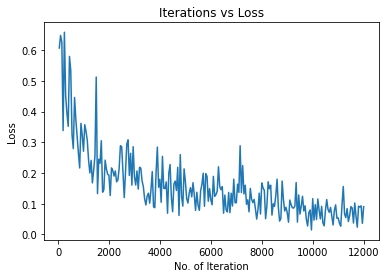

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(iteration_list, loss_list)
plt.xlabel('No. of Iteration')
plt.ylabel('Loss')
plt.title('Iterations vs Loss')
plt.show()

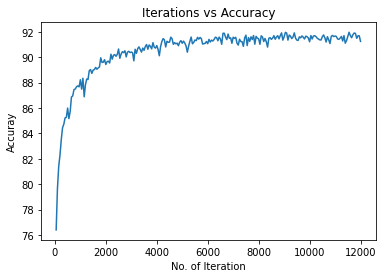

In [15]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel('No. of Iteration')
plt.ylabel('Accuray')
plt.title('Iterations vs Accuracy')
plt.show()

In [16]:
output_label = [
                'T-shirt/top',  'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot'
]

In [17]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    test = Variable(images)
    outputs = model(test)
    predicted = torch.max(outputs, 1)[1]
    c = (predicted == labels).squeeze()

    for i in range(100):
      label = labels[i]
      class_correct[label] += c[i].item()
      total_correct[label] += 1

  for i in range(10):
    print('Accuracy of {}: {:.2f}%'.format(output_label[i], class_correct[i]*100/total_correct[i]))

Accuracy of T-shirt/top: 85.70%
Accuracy of Trouser: 98.00%
Accuracy of Pullover: 87.00%
Accuracy of Dress: 91.10%
Accuracy of Coat: 87.90%
Accuracy of Sandal: 98.90%
Accuracy of Shirt: 79.40%
Accuracy of Sneaker: 97.40%
Accuracy of Bag: 97.80%
Accuracy of Ankle-boot: 96.40%


In [18]:
from itertools import chain

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [19]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_l, predictions_l)
print('Classification report for CNN :\n%s\n'
% (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.85      0.85      0.85    240000
           1       0.99      0.98      0.98    240000
           2       0.84      0.86      0.85    240000
           3       0.90      0.91      0.91    240000
           4       0.84      0.85      0.84    240000
           5       0.98      0.98      0.98    240000
           6       0.75      0.71      0.73    240000
           7       0.95      0.97      0.96    240000
           8       0.98      0.98      0.98    240000
           9       0.97      0.96      0.96    240000

    accuracy                           0.90   2400000
   macro avg       0.90      0.90      0.90   2400000
weighted avg       0.90      0.90      0.90   2400000




In [20]:
# save model
path = 'drive/MyDrive/pytorch/practice2/ffmodel.pt'
torch.save(model.state_dict(), path)